# Task 3: Embeddings as Features

## Imports

In [2]:
import gensim.downloader as api
import nltk
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

## 3.1 Loading pre-trained embedding model

In [2]:
# Pre-trained model with google news dataset, covering 3 million words and phrases (vector size of 300)
embeddings = api.load('word2vec-google-news-300')

### Loading dataset

In [3]:
with gzip.open("dataset/goemotions.json.gz", "rb") as f:
    data = json.loads(f.read())

dataset = np.array(data)

# Extracting posts, emotions and sentiments
posts = dataset[:, 0]
emotions = dataset[:, 1]
sentiments = dataset[:, 2]

## 3.7 Save performance of the models

In [4]:
# Function to save output to text files
def save_output(model_name, classification_task, y_test, y_pred, fileName, estimator, useGridSearchCV, hyper_parameters=None):
    with open(fileName, 'a') as f:

        if(not useGridSearchCV):
            # Model name + hyper parameters + classification task
            f.writelines(['===========================================================\n',
                          model_name + ' for --> ' + classification_task + '\nDefault Parameters: ' + str(estimator.get_params()) + '\n'
                          , '===========================================================\n'])
        else:
            f.writelines(['===========================================================\n',
                          model_name + ' for --> ' + classification_task + '\nProvided Hyper-Parameters: ' + str(hyper_parameters) 
                          + '\n' + 'Best Estimator: ' + str(estimator.best_estimator_) + '\n' 
                          + 'Best Parameters: ' + str(estimator.best_params_) + '\n'
                          , '===========================================================\n'])
        # Confusion Matrix
        f.write('\nConfusion Matrix:\n-----------------\n\n' + str(confusion_matrix(y_test, y_pred)) + '\n')
        
        # Classfication Report
        f.write('\nClassification Report:\n----------------------\n\n' + classification_report(y_test, y_pred) + '\n\n')

In [5]:
# Function to display a visual confusion matrix
def displayVisualConfusionMatrix(y_pred, y_test, classification_task):
    print("Classification task: ", classification_task)
    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
    if(classification_task == 'Emotions'):
        fig = cm.ax_.get_figure()
        fig.set_figwidth(13)
        fig.set_figheight(13)
        plt.show()
    else:
        plt.show()

## 3.2 Tokenizing Reddit posts using nltk

In [6]:
# Function to tokenize each Reddit post from a list and store them in a list ex) [['That','game','hurt','.'],...]
def tokenizePosts(posts):
    tokenizedPostsList = []
    for post in posts:
        tokenizedPostsList.append(nltk.word_tokenize(post)) 
    return tokenizedPostsList

In [7]:
tokenizedPostsList = tokenizePosts(posts)

In [8]:
# Splitting training and testing dataset for tokenized posts and emotions
# ex) [['That','game','hurt','.'],...]
x_train, x_test, y_train_emo, y_test_emo, y_train_sen, y_test_sen = train_test_split(tokenizedPostsList, emotions, sentiments, test_size=0.2, random_state=0)

In [9]:
# Function to count number of tokens in our training set
def countTokens(x_train):
    count = 0
    for post in x_train:
        count = count + len(post)
    return count

In [10]:
print("Number of tokens in training set: ", countTokens(x_train))

Number of tokens in training set:  2112422


## 3.3 Computing the embedding of a Reddit post

In [11]:
# Function that computes the embeddings of Reddit posts as the average of the embeddings of the words in each post
def computeAvgPostEmbedding(embeddings, tokenizedPostsList, vector_size):
    avgPostEmbeddingsList = []
    
    for post in tokenizedPostsList:
        #Removing words that are not in the vocabulary (embedding of Word2Vec)
        filteredPost = [w for w in post if w in embeddings.index_to_key]
        if len(filteredPost)>=1:
            avgPostEmbeddingsList.append(np.mean(embeddings[filteredPost],axis=0))
        else:
            avgPostEmbeddingsList.append([0 for i in range(vector_size)])
            
    return avgPostEmbeddingsList

In [12]:
# Taking the first Reddit post as an example to show its embedding
onePost = [tokenizedPostsList[0]]

In [13]:
print( "This is an average embedding of one Reddit post 'That game hurt.': \n", computeAvgPostEmbedding(embeddings, onePost, 300))

This is an average embedding of one Reddit post 'That game hurt.': 
 [array([-0.00927226,  0.09049479,  0.11995443,  0.05528768, -0.02148438,
        0.10862223,  0.10921224, -0.09202067,  0.13647461,  0.22639973,
        0.05769857, -0.2006836 ,  0.06179746, -0.05258179, -0.10085043,
        0.03808594,  0.17382812,  0.06542969,  0.08292643, -0.1258138 ,
        0.05615234,  0.11732992,  0.07641602, -0.08479818, -0.0394694 ,
       -0.05236816, -0.13671875, -0.08813477,  0.15940349,  0.07944743,
        0.01871745,  0.02229818,  0.08378092, -0.07779948,  0.1340332 ,
        0.10400391,  0.00097656,  0.15413411,  0.08333334,  0.26529947,
        0.16451009,  0.01660156,  0.19360352, -0.10611979, -0.12532552,
       -0.04524739,  0.01879883, -0.04329427,  0.19498698,  0.18204753,
       -0.1044108 ,  0.1508789 ,  0.03904216, -0.07497152,  0.06602732,
       -0.0071818 ,  0.08284505, -0.0320638 ,  0.06225586, -0.11344401,
       -0.06217448,  0.04394531, -0.08780924, -0.08268229, -0.0646

## 3.4 Computing overall hit rate of training and test sets

In [16]:
# Function to compute the hit rates (the % of words in the Reddit posts for which an embedding is found in Word2Vec)
def computeHitRate(embeddings, postList, setType):
    filteredPost = []
    for post in postList:
        filteredPost.append([w for w in post if w in embeddings.index_to_key])
    
    hitRate = countTokens(filteredPost)/countTokens(postList)*100
    print(setType," hit rate: ", round(hitRate,2) , "%")

In [17]:
computeHitRate(embeddings, x_train, "Train set")

Train set  hit rate:  77.44 %


In [18]:
computeHitRate(embeddings, x_test, "Test set")

Test set  hit rate:  77.5 %


### Data preparation for training and testing

In [14]:
# Average embeddings list of train set (vector form of x_train)
trainAvgEmbeddingsList = computeAvgPostEmbedding(embeddings, x_train, 300)

In [15]:
# Average embeddings list of test set (vector form of x_test)
testAvgEmbeddingsList = computeAvgPostEmbedding(embeddings, x_test, 300)

## 3.5 Base Multi-Layered Perceptron (Base-MLP) with default parameters

In [16]:
# Although we are asked to use default parameters and dataset is large, the MLP model takes too long to train. 
# Hence, we set a parameter of max iteration to 2.
def BaseMLPClassifier(feature, label, x_test, y_test, classification_task, fileName):
    MLP = MLPClassifier(max_iter=2)
    MLP.fit(feature, label) # training
    y_pred = MLP.predict(x_test) # testing
    displayVisualConfusionMatrix(y_pred, y_test, classification_task)
    save_output('Base Multi-Layered Perceptron Model', classification_task, y_test, y_pred, fileName, MLP, False)    

### Training and testing with Base MLP

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification task:  Emotions


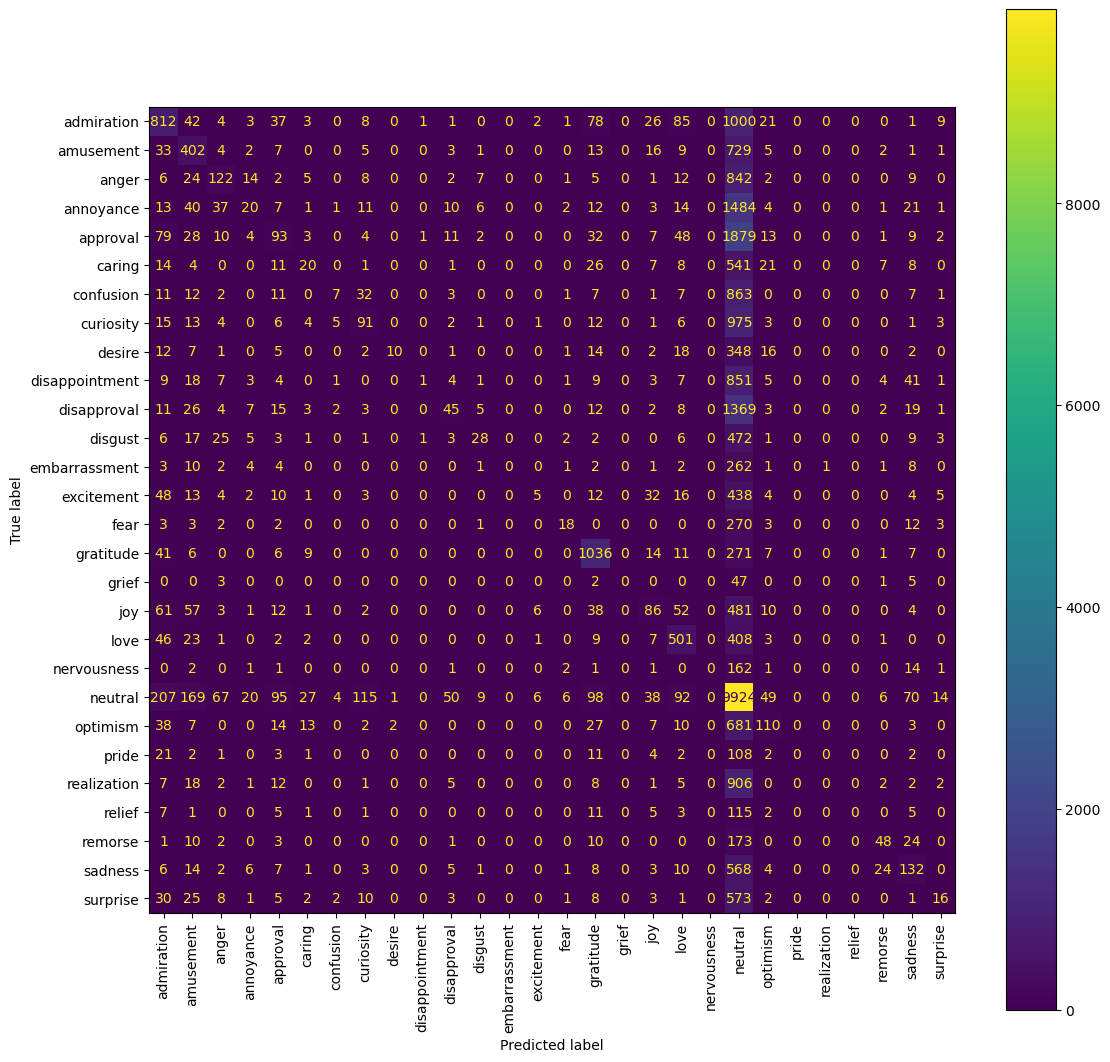

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Classification Task: Emotions
BaseMLPClassifier(trainAvgEmbeddingsList, y_train_emo, testAvgEmbeddingsList, y_test_emo, 'Emotions', 'googleNews_performance.txt')

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification task:  Sentiments


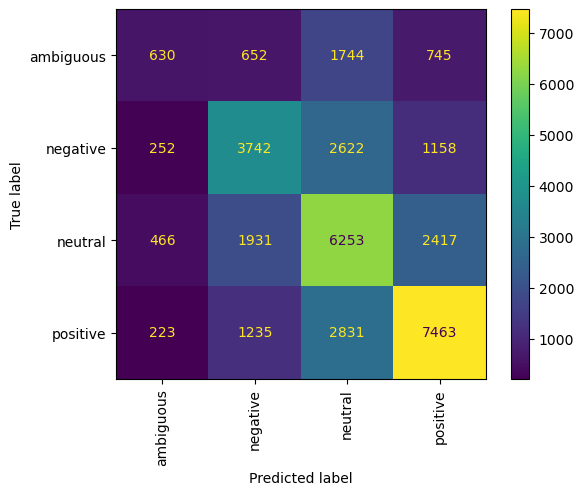

In [18]:
# Classification Task: Sentiments
BaseMLPClassifier(trainAvgEmbeddingsList, y_train_sen, testAvgEmbeddingsList, y_test_sen, 'Sentiments', 'googleNews_performance.txt')

#### Number of CPUs on system to use for the n_jobs parameter in GridSearchCV

In [1]:
# n_jobs = number of processors used to run jobs in parallel to speed up the process
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

NameError: name 'os' is not defined

## 3.6 Top Multi-Layered Perceptron (Top-MLP)

In [19]:
# Hyper parameters for Top-MLP
MLPparams = {'activation': ('relu','logistic'),
            'hidden_layer_sizes': ((80,), (10,10)),
            'solver': ('adam','sgd'),
            'max_iter': [30],
            'learning_rate_init': [0.01],
            'learning_rate': ['constant'],
            'batch_size': [300]}

# Because the dataset is too large, the MLP model takes too long to train. Hence, we set a parameter of max
# iteration to 2. 
def TopMLPClassifier(feature, label, x_test, y_test, classification_task, fileName):
    TopMLP = GridSearchCV(estimator=MLPClassifier(), param_grid=MLPparams, scoring='f1_weighted', n_jobs=n_cpu-1)
    TopMLP.fit(feature, label)
    y_pred = TopMLP.predict(x_test)
    displayVisualConfusionMatrix(y_pred, y_test, classification_task)
    save_output('Top Multi-Layered Perceptron Model', classification_task, y_test, y_pred, fileName, TopMLP, True, MLPparams)

### Training and testing with Top MLP

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

Classification task:  Emotions


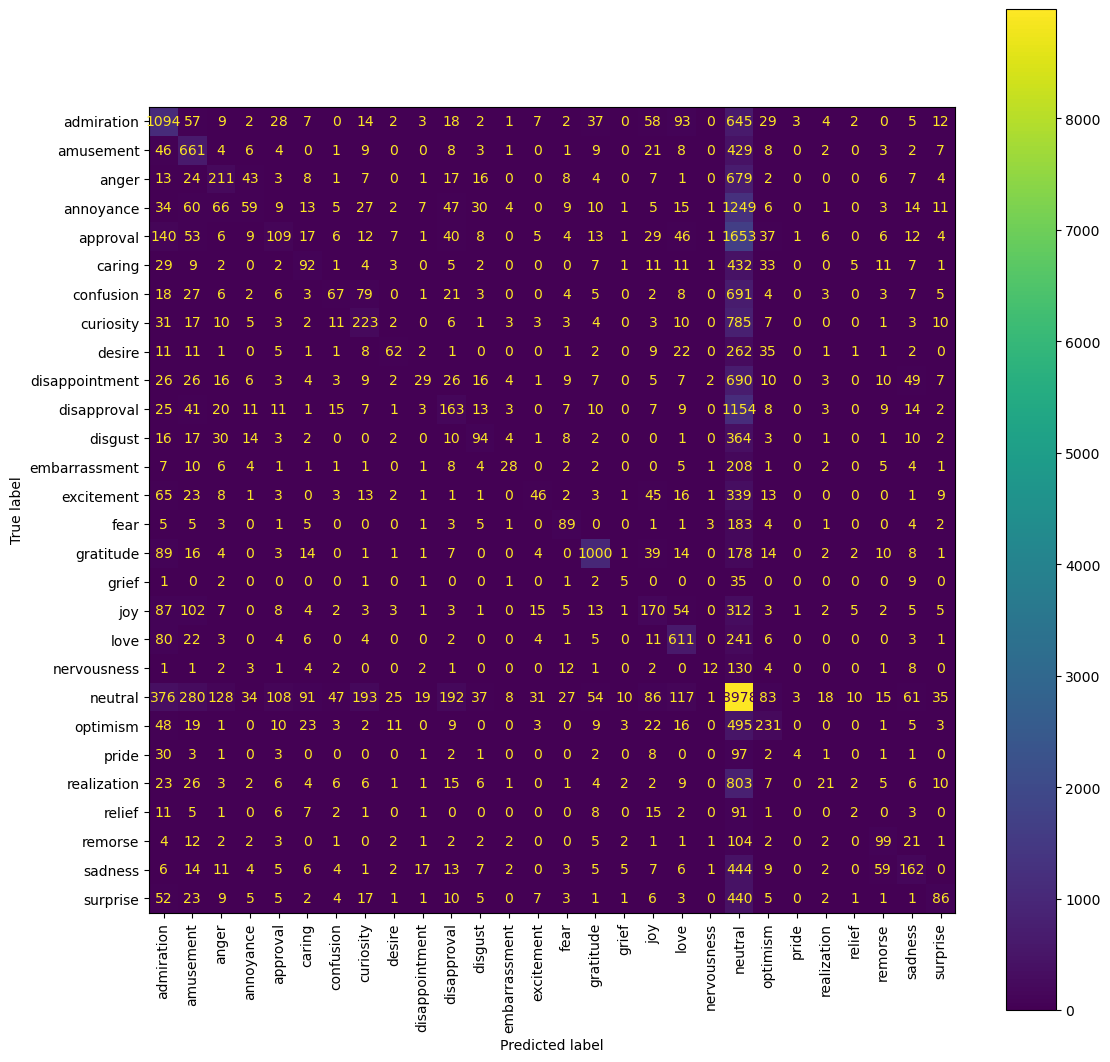

In [20]:
# Classification Task: Emotions
TopMLPClassifier(trainAvgEmbeddingsList, y_train_emo, testAvgEmbeddingsList, y_test_emo, 'Emotions', 'googleNews_performance.txt')

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

Classification task:  Sentiments


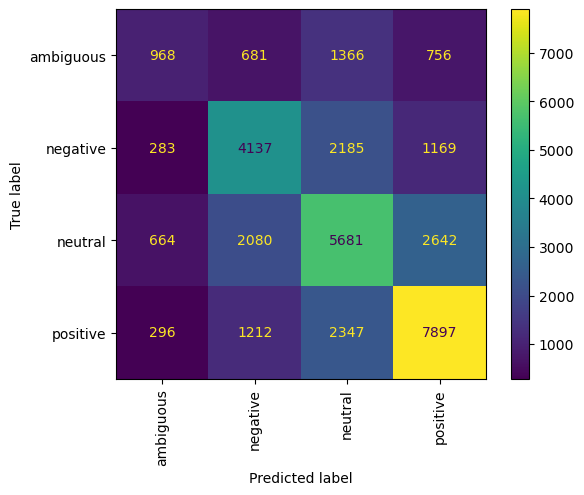

In [21]:
# Classification Task: Sentiments
TopMLPClassifier(trainAvgEmbeddingsList, y_train_sen, testAvgEmbeddingsList, y_test_sen, 'Sentiments', 'googleNews_performance.txt')

## 3.8 Exploration with 2 other English pretrained embedding models

### Pretrained embedding model 1: Wiki Embeddings

In [22]:
# vector size of 100
wikiEmbeddings = api.load('glove-wiki-gigaword-100')

#### Data preparation for training and testing

In [23]:
# Average embeddings list of x_train with Wiki embeddings
trainWiki = computeAvgPostEmbedding(wikiEmbeddings, x_train, 100)

In [24]:
# Average embeddings list of x_test with Wiki embeddings
testWiki = computeAvgPostEmbedding(wikiEmbeddings, x_test, 100)

#### Training and testing with chosen best performing model: Top MLP

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

Classification task:  Emotions


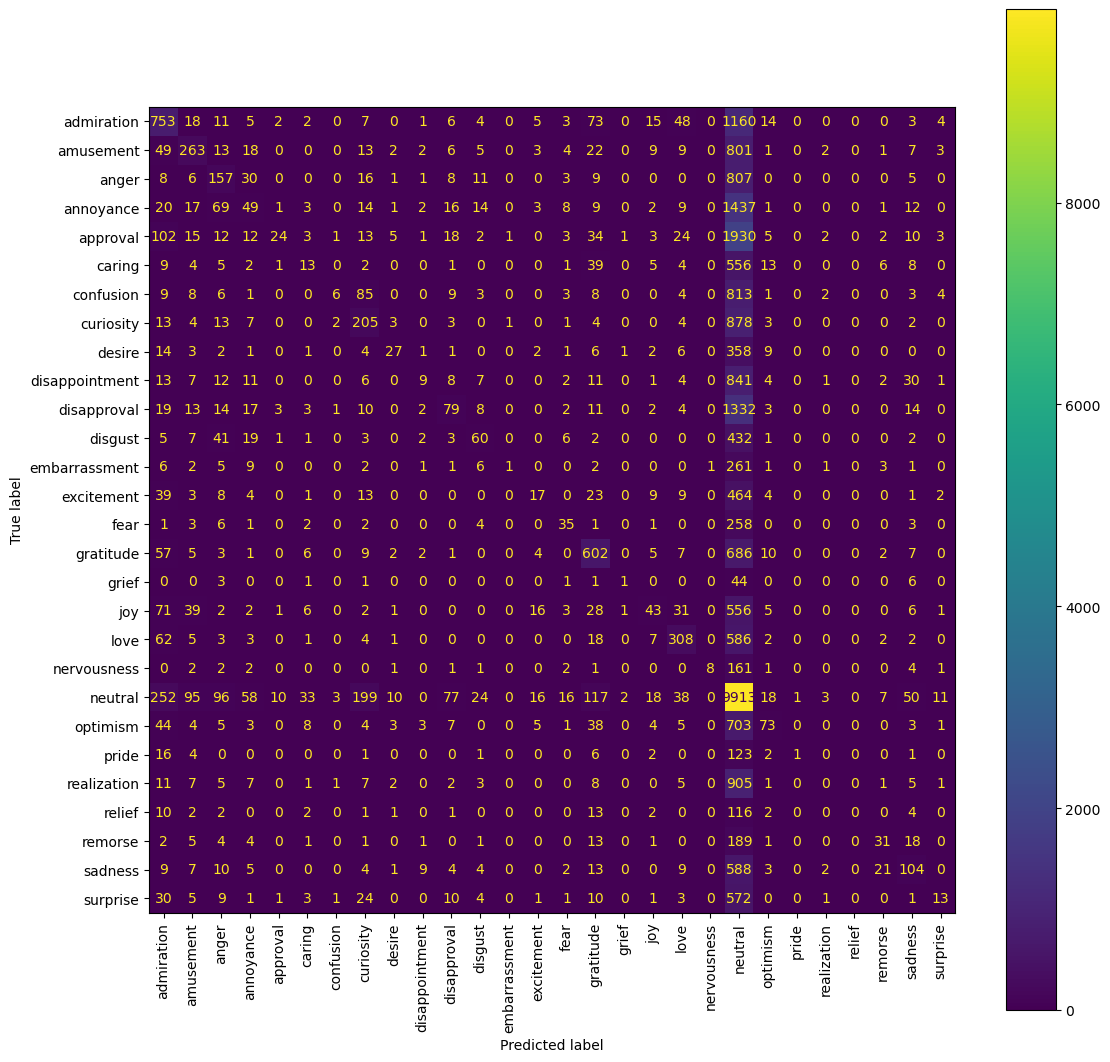

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Classification Task: Emotions
TopMLPClassifier(trainWiki, y_train_emo, testWiki, y_test_emo, 'Emotions', 'wiki_performance.txt')

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

Classification task:  Sentiments


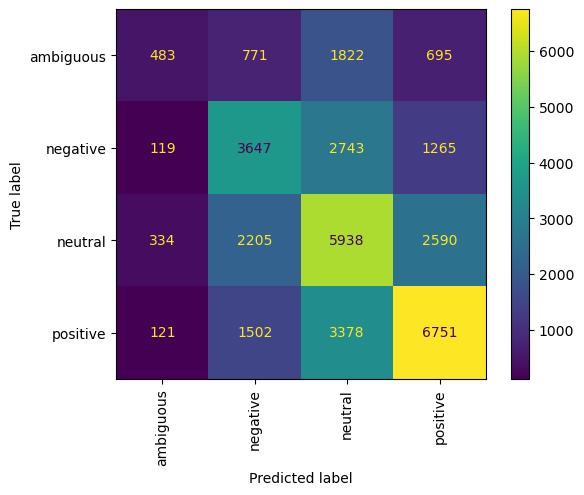

In [26]:
# Classification Task: Sentiments
TopMLPClassifier(trainWiki, y_train_sen, testWiki, y_test_sen, 'Sentiments', 'wiki_performance.txt')

### Pretrained embedding model 2: Twitter Embeddings

In [27]:
# vector size of 200
twitterEmbeddings = api.load('glove-twitter-200')

#### Data preparation for training and testing

In [28]:
# Average embeddings list of x_train with Twitter embeddings
trainTwitter = computeAvgPostEmbedding(twitterEmbeddings, x_train, 200)

In [29]:
# Average embeddings list of x_test with Twitter embeddings
testTwitter = computeAvgPostEmbedding(twitterEmbeddings, x_test, 200)

#### Training and testing with chosen best performing model: Top MLP

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

Classification task:  Emotions


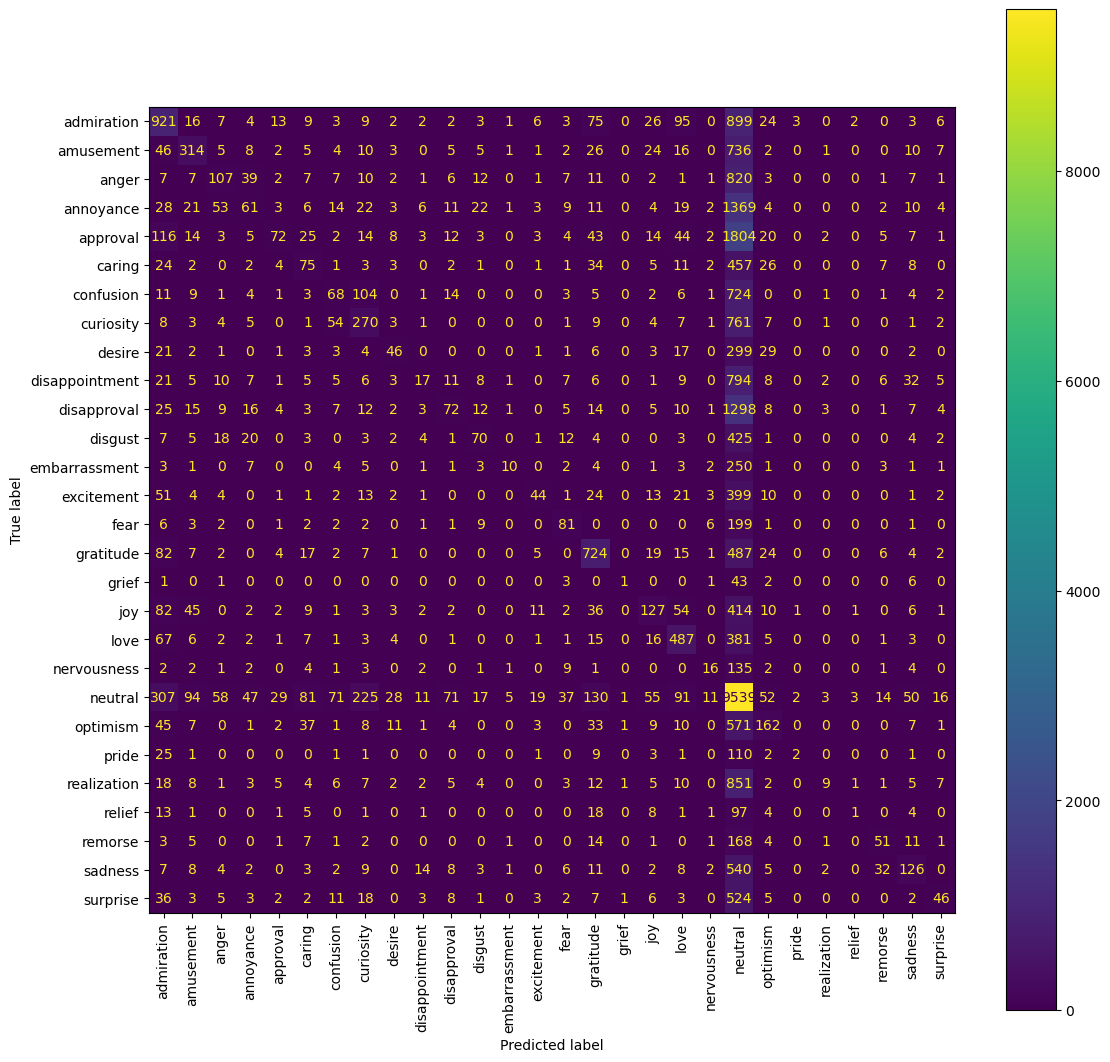

In [30]:
# Classification Task: Emotions
TopMLPClassifier(trainTwitter, y_train_emo, testTwitter, y_test_emo, 'Emotions', 'twitter_performance.txt')

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\miniconda3\envs\comp472\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Duong\minic

Classification task:  Sentiments


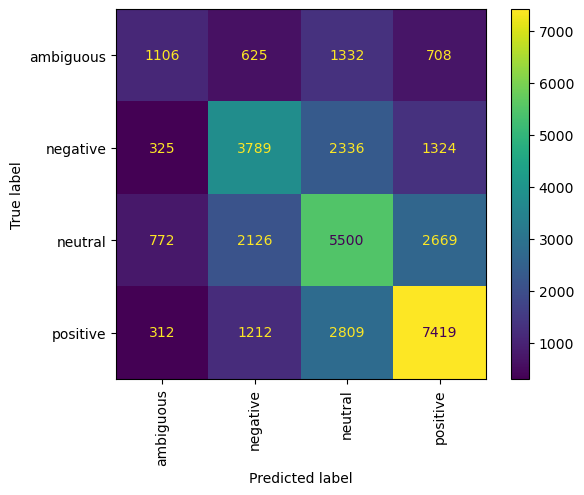

In [31]:
# Classification Task: Sentiments
TopMLPClassifier(trainTwitter, y_train_sen, testTwitter, y_test_sen, 'Sentiments', 'twitter_performance.txt')